In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import math
import xgboost as xgb
from scipy.stats import skew
from scipy import stats
import statsmodels
from sklearn.metrics import accuracy_score

import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")

# full_data = [train, test]

In [3]:
train = train.set_index("PassengerId")
train['train'] = 1
test = test.set_index("PassengerId")
test['train'] = 0

data = train.append(test, ignore_index=True)

In [4]:
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [5]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'train'],
      dtype='object')

In [6]:
data.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


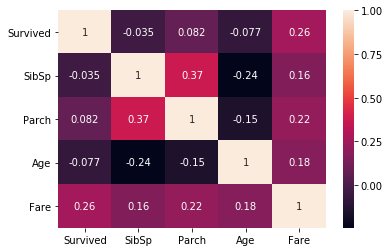

In [7]:
 g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

In [132]:
def compare_dist(data, var1, var2):
    print(data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
    as_index=False).mean().sort_values(by=var2, ascending=False))
    g = sns.FacetGrid(data, col=var2).map(plt.hist, var1)
    
def compare_mean(data, var1, var2):
    return data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
        as_index=False).mean().sort_values(by=var2, ascending=False)


def compare_hist(data, var):
    max_range = data[var].max() * 1.2
    bins = np.linspace(0, max_range)
    plt.hist(data[data['Survived']==0][var], bins,
            alpha=0.5, normed=True, label='Did Not Survive')
    plt.hist(data[data['Survived']==1][var], bins,
            alpha=0.5, normed=True, label='Survived')
    plt.legend(loc='upper right')
    plt.show()
    
def categorical_survival_rate(data, var):
    all_counts = dict(data[var].value_counts())
    survived_counts = dict(data[var][data['Survived']==1].value_counts())
    died_counts = dict(data[var][data['Survived']==0].value_counts())
    
    categories = list(data[var].unique())
    categories = [category for category in categories if str(category) != 'nan']
    try:
        categories.sort()
    except TypeError:
        print("TypeError")
    survived_rate=[]
    died_rate=[]
    
    for category in categories:
        survived_rate.append(survived_counts[category] / all_counts[category])
        died_rate.append(died_counts[category] / all_counts[category])
        
    for i, category in enumerate(categories):
        categories[i] = str(category)
        
    plt.bar(categories, survived_rate, align='center', alpha=0.5, color = 'r')
    plt.ylabel('Survival Rate')
    plt.title(f'Survival Rate by {var}')
    plt.show()

    plt.bar(categories, died_rate, align='center', alpha=0.5, color = 'b')
    plt.ylabel('Death Rate')
    plt.title(f'Death Rate by {var}')
    plt.show()

### Parch vs Survivied

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


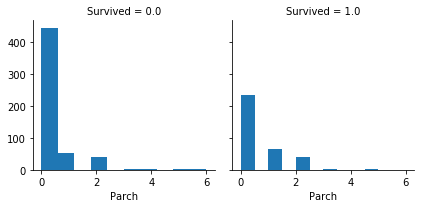

In [10]:
compare_dist(data, 'Parch', 'Survived')

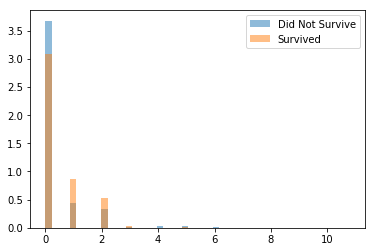

In [11]:
compare_hist(data, 'Parch')

### SibSp vs Survived

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


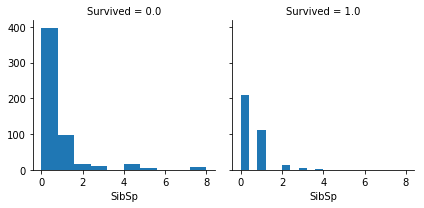

In [12]:
compare_dist(data, 'SibSp', 'Survived')

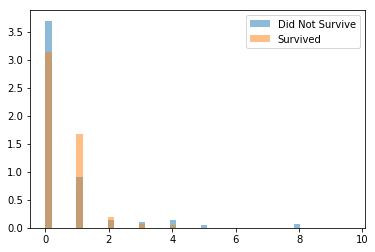

In [13]:
compare_hist(data, 'SibSp')

### Fare vs Survived

         Fare  Survived
247  512.3292       1.0
196   57.9792       1.0
89    13.8583       1.0
88    13.7917       1.0
86    13.4167       1.0
83    12.6500       1.0
81    12.4750       1.0
79    12.2875       1.0
194   56.9292       1.0
77    12.0000       1.0
195   57.0000       1.0
74    11.1333       1.0
197   59.4000       1.0
52     8.5167       1.0
201   63.3583       1.0
202   65.0000       1.0
68     9.8417       1.0
204   69.3000       1.0
207   71.2833       1.0
209   75.2500       1.0
210   76.2917       1.0
211   76.7292       1.0
213   77.9583       1.0
214   78.2667       1.0
90    13.8625       1.0
191   55.4417       1.0
190   55.0000       1.0
188   52.5542       1.0
142   26.3875       1.0
141   26.2875       1.0
..        ...       ...
158   31.2750       0.0
136   25.9250       0.0
156   30.6958       0.0
147   27.9000       0.0
148   28.5000       0.0
113   18.0000       0.0
176   40.1250       0.0
198   61.1750       0.0
95    14.4583       0.0
71    10.4625   

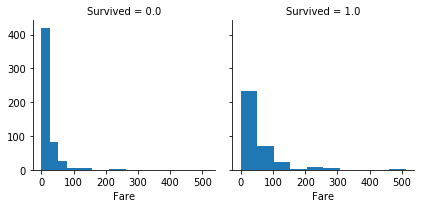

In [14]:
compare_dist(data, 'Fare', 'Survived')

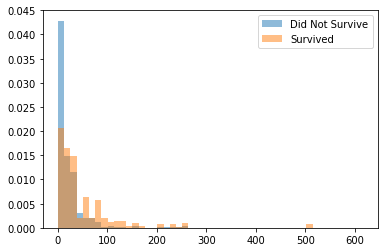

In [15]:
compare_hist(data, 'Fare')

### Age vs Survived

      Age  Survived
0    0.42  1.000000
9    5.00  1.000000
79  63.00  1.000000
68  53.00  1.000000
1    0.67  1.000000
17  13.00  1.000000
16  12.00  1.000000
87  80.00  1.000000
2    0.75  1.000000
4    0.92  1.000000
3    0.83  1.000000
7    3.00  0.833333
20  15.00  0.800000
5    1.00  0.714286
8    4.00  0.700000
10   6.00  0.666667
63  48.00  0.666667
64  49.00  0.666667
47  35.00  0.611111
35  27.00  0.611111
74  58.00  0.600000
31  24.00  0.500000
65  50.00  0.500000
70  55.00  0.500000
72  56.00  0.500000
76  60.00  0.500000
78  62.00  0.500000
43  32.50  0.500000
42  32.00  0.500000
67  52.00  0.500000
..    ...       ...
13   9.00  0.250000
15  11.00  0.250000
27  21.00  0.208333
25  20.00  0.200000
57  43.00  0.200000
50  37.00  0.166667
62  47.00  0.111111
84  70.50  0.000000
83  70.00  0.000000
80  64.00  0.000000
81  65.00  0.000000
85  71.00  0.000000
86  74.00  0.000000
75  59.00  0.000000
77  61.00  0.000000
82  66.00  0.000000
40  30.50  0.000000
14  10.00  0.000000


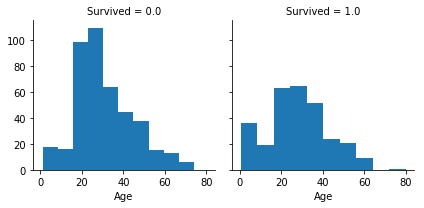

In [16]:
compare_dist(data, 'Age', 'Survived')

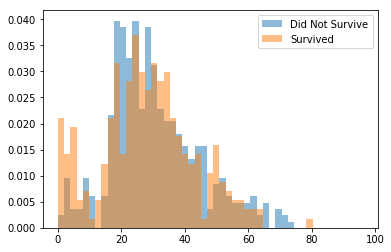

In [17]:
compare_hist(data, 'Age')

### Sex vs Survived

In [18]:
compare_mean(data, 'Sex', 'Survived')

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [107]:
# all_counts = dict(data['Sex'].value_counts())
# survived_counts = dict(data['Sex'][data['Survived']==1].value_counts())
# died_counts = dict(data['Sex'][data['Survived']==0].value_counts())


# genders = ['male', 'female']
# survived_rate = [survived_counts['male'] / all_counts['male'],
#                  survived_counts['female'] / all_counts['female']]
# died_list = [died_counts['male'] / all_counts['male'],
#              died_counts['female'] / all_counts['female']]

In [108]:
# plt.bar(genders, survived_rate, align='center', alpha=0.5, color = 'r')
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Gender')
# plt.show()

# plt.bar(genders, died_list, align='center', alpha=0.5, color = 'b')
# plt.ylabel('Death Rate')
# plt.title('Death Rate by Gender')
# plt.show()

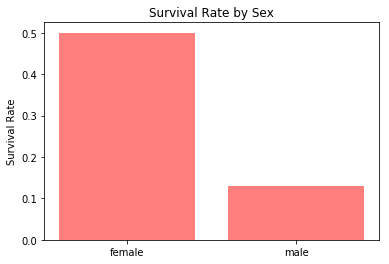

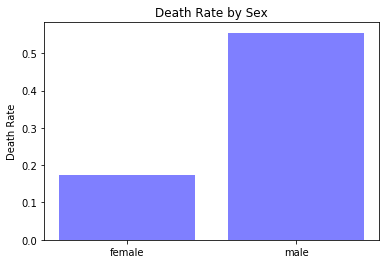

In [119]:
categorical_survival_rate(data, 'Sex')

### Pclass vs Survived


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


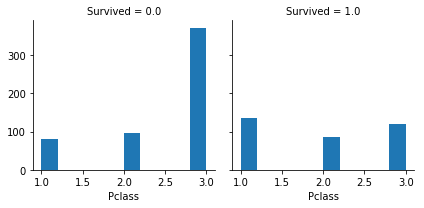

In [57]:
compare_dist(data, 'Pclass', 'Survived')

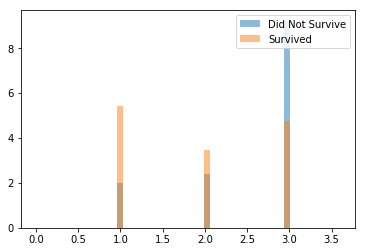

In [59]:
compare_hist(data, 'Pclass')

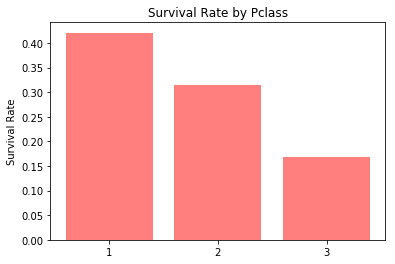

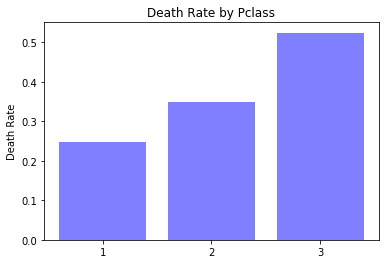

In [120]:
categorical_survival_rate(data, 'Pclass')

In [116]:
# all_counts = dict(data['Pclass'].value_counts())
# survived_counts = dict(data['Pclass'][data['Survived']==1].value_counts())
# died_counts = dict(data['Pclass'][data['Survived']==0].value_counts())


# p_class = ['1', '2', '3']
# survived_rate = [survived_counts[1] / all_counts[1],
#                  survived_counts[2] / all_counts[2],
#                 survived_counts[3] / all_counts[3]]
# died_list = [died_counts[1] / all_counts[1],
#              died_counts[2] / all_counts[2],
#             died_counts[3] / all_counts[3]]

In [117]:
# plt.bar(p_class, survived_rate, align='center', alpha=0.5, color = 'r')
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Class')
# plt.show()

# plt.bar(p_class, died_list, align='center', alpha=0.5, color = 'b')
# plt.ylabel('Death Rate')
# plt.title('Death Rate by Class')
# plt.show()

### Embarked vs Survived

In [69]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [114]:
compare_mean(data, 'Embarked', 'Survived')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


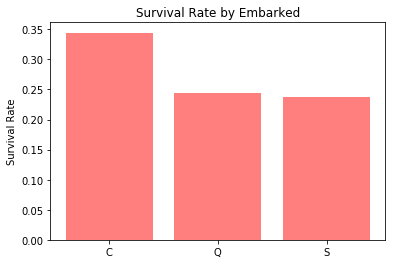

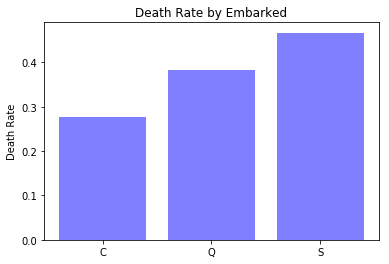

In [133]:
categorical_survival_rate(data, 'Embarked')

## Feature Engineering/ Data Cleaning

In [141]:
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
train             0
Name_length       0
FamilySize        0
IsAlone           0
dtype: int64

In [134]:
data['Name_length'] = data['Name'].apply(len)

In [135]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [146]:
data['FamilySize'].describe()

count    1309.000000
mean        1.883881
std         1.583639
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: FamilySize, dtype: float64

In [140]:
data['IsAlone'] = np.where(data["FamilySize"]==1, 1, 0)

In [142]:
data['Embarked'] = data['Embarked'].fillna('S')

In [143]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [144]:
data['Fare'].describe()

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [155]:
data['CategoricalFare'] = pd.qcut(data['Fare'], 5, labels = ['first', 'second', 'third', 'fourth',
                                  'fifth'])

In [154]:
pd.qcut(data['Fare'], 5, labels = ['first', 'second', 'third', 'fourth',
                                  'fifth'])

0        first
1        fifth
2       second
3        fifth
4       second
5       second
6        fifth
7        third
8        third
9       fourth
10       third
11      fourth
12      second
13      fourth
14       first
15       third
16      fourth
17       third
18       third
19       first
20      fourth
21       third
22      second
23      fourth
24       third
25      fourth
26       first
27       fifth
28      second
29      second
         ...  
1279     first
1280     third
1281     fifth
1282    fourth
1283     third
1284    second
1285    fourth
1286     fifth
1287     first
1288     fifth
1289     first
1290     first
1291     fifth
1292     third
1293     fifth
1294     fifth
1295    fourth
1296     third
1297    second
1298     fifth
1299     first
1300     third
1301     first
1302     fifth
1303     first
1304    second
1305     fifth
1306     first
1307    second
1308    fourth
Name: Fare, Length: 1309, dtype: category
Categories (5, object): [first < second < t

In [150]:
help(pd.qcut)

Help on function qcut in module pandas.core.reshape.tile:

qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
    Quantile-based discretization function. Discretize variable into
    equal-sized buckets based on rank or based on sample quantiles. For example
    1000 values for 10 quantiles would produce a Categorical object indicating
    quantile membership for each data point.
    
    Parameters
    ----------
    x : 1d ndarray or Series
    q : integer or array of quantiles
        Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
        array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles
    labels : array or boolean, default None
        Used as labels for the resulting bins. Must be of the same length as
        the resulting bins. If False, return only integer indicators of the
        bins.
    retbins : bool, optional
        Whether to return the (bins, labels) or not. Can be useful if bins
        is given as a scalar.
 

In [ ]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
pd.crosstab(train['Title'], train['Sex'])

In [ ]:
rare_values = []

In [ ]:
train[['Title', 'Survived', 'Age']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = train, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

In [ ]:
data_df.head()

In [ ]:
help(sns.heatmap)

In [ ]:
help(pd.read_csv)